# Matrix Completion Notebook
Contains examples of how to use the MatrixCompletion class and far below the original code and experiments

#### First install the needed packages on the instance if not already done. 

Now import necessary packages for this notebook:

In [1]:
import pandas as pd
import numpy as np
import math 
from random import Random
from src.matrix_completion import matrix_completion as MC
from src.data_prep_functions import data_prep_functions as dpf
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


/opt/cortex-installs/miniconda/envs/cortex-python3/lib/python3.10/site-packages/h2o/backend/connection.py:390: UserWarning: Proxy is defined in the environment: http_proxy. This may interfere with your H2O Connection.
  warn("Proxy is defined in the environment: %s. "


H2O_cluster_uptime:,4 hours 34 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.4
H2O_cluster_version_age:,1 month and 9 days
H2O_cluster_name:,H2O_from_python_LM5188096F336D_hz0c6g
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.667 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


Read in the data from LM. This is currently stored on the repo as it was initially the easiest option, but can be changed. 

This is the updated data-set after the initial one was changed by LM on the 11th of Nov 2021

In [2]:
# read in the data. This is the data at the policy level with all features.
df = pd.read_csv("Data/newdata.csv")

/tmp/ipykernel_23251/3942952060.py:2: DtypeWarning: Columns (9,11,13,17,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Data/newdata.csv")


First, we will use synthetic data as an example: 

In [3]:
n = 10000
m = 30
r = 10
U = np.random.rand(n, r)
V = np.random.rand(m, r)
M = U @ V.T 

E = np.random.normal(size = (n, m))*0.1
O = M + E
O = (O - np.mean(O)) / np.std(O)

In [4]:
synth = pd.DataFrame(O)
mat = MC.MatrixCompletion(synth, masking_method='uniform', masking_proportion = 0.4)

Creating uniform mask with seed (2022,). To input custom mask, input mask when initializing or use method 'set_custom_mask()'


We can run the matrix completion for a certain number of factors, or run a gridsearch over the number of factors: 

In [5]:
synth_mat, synth_r2, synth_r2_cols = mat.run_completion(10, tolerance=1e-3)

Running matrix completion for 10 factors:

Overall R^2 value:
0.8754371029322506


In [6]:
synth_mat, synth_r2, synth_r2_cols = mat.run_completion_gridsearch(factor_range=range(3, 20), tolerance=1e-3)

Running matrix completion for 3 factors:

Overall R^2 value:
0.7587139041125792
Running matrix completion for 4 factors:

Overall R^2 value:
0.7846451596357916
Running matrix completion for 5 factors:

Overall R^2 value:
0.8105231345497819
Running matrix completion for 6 factors:

Overall R^2 value:
0.8245177529833083
Running matrix completion for 7 factors:

Overall R^2 value:
0.8387941850560849
Running matrix completion for 8 factors:

Overall R^2 value:
0.8533214228572282
Running matrix completion for 9 factors:

Overall R^2 value:
0.8675836592240053
Running matrix completion for 10 factors:

Overall R^2 value:
0.8754371029322506
Running matrix completion for 11 factors:

Overall R^2 value:
0.8754046337276605
Running matrix completion for 12 factors:

Overall R^2 value:
0.7136890760619501
Running matrix completion for 13 factors:

Overall R^2 value:
0.6298470051989875
Running matrix completion for 14 factors:

Overall R^2 value:
0.5013258887755958
Running matrix completion for 15 fa

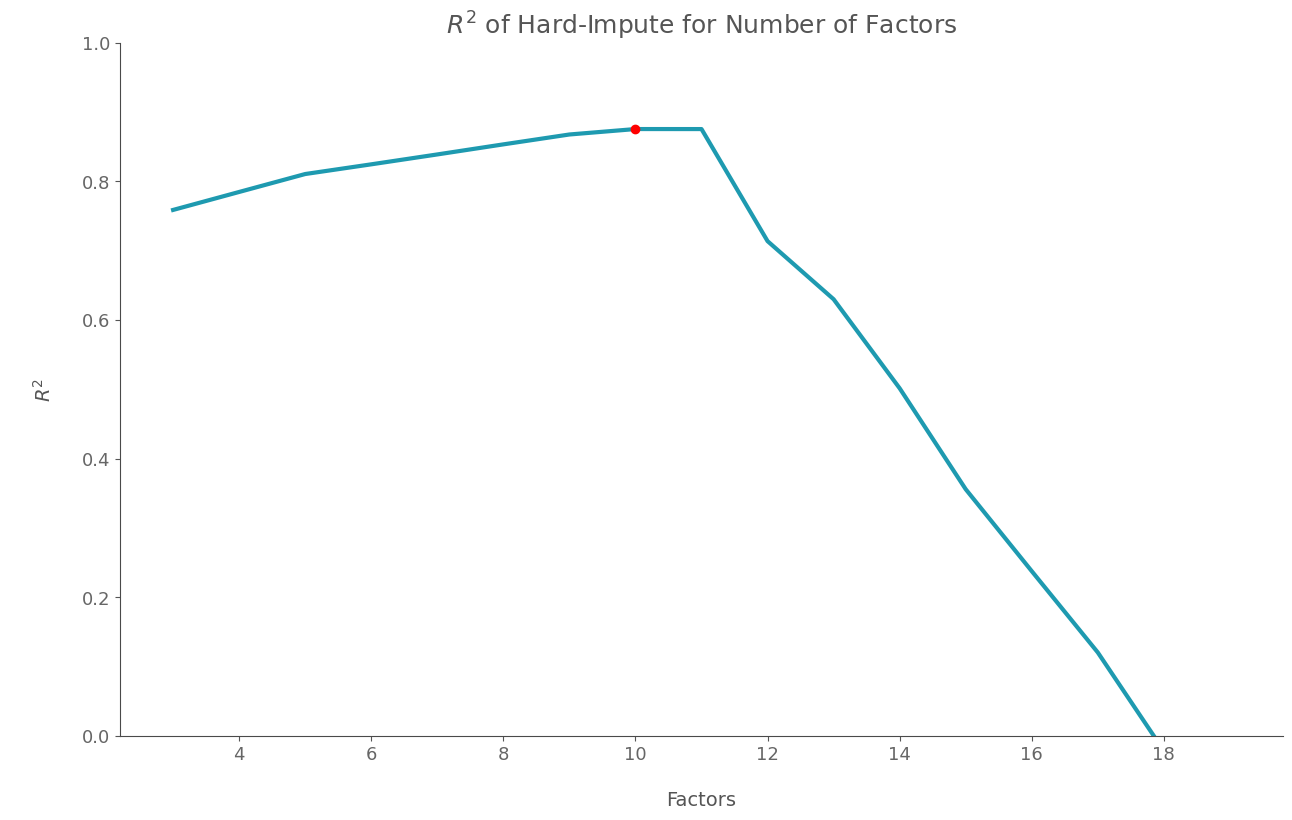

In [7]:
mat.plot_gridsearch_results()

### Now the actual Liberty Mutual dataset
Transform the data as in the initial modeling. We need only impute data for the features in the baseline model, and should get the matrix in its standardised form. 

In [8]:
df_bucket_X = dpf.get_rolled_up_df(df)

/mnt/LM5188096F336D/grs-pricing-high-dimensional-imputation/PythonScripts/data_prep_functions.py:82: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_agg = df.groupby(['Acct_Num', 'Pol_Eff_Date'], as_index=False).mean()
/mnt/LM5188096F336D/grs-pricing-high-dimensional-imputation/PythonScripts/data_prep_functions.py:94: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_sum =  df_manip.groupby(['Acct_Num', 'Pol_Eff_Date'], as_index=False).sum()
/mnt/LM5188096F336D/grs-pricing-high-dimensional-imputation/PythonScripts/data_prep_functions.py:102: FutureWarning: The default value of numeric_only in DataFrameGroupB

Final dataframe shape:

In [9]:
df_bucket_X.shape

(39367, 32)

Now, again, we can create a MatrixCompletion object using this data:

In [13]:
mat = MC.MatrixCompletion(df_bucket_X, masking_method='uniform', masking_proportion=0.1)

Creating uniform mask with seed (2022,). To input custom mask, input mask when initializing or use method 'set_custom_mask()'


In [9]:
agg_grid_mat, agg_grid_r2, agg_grid_r2_cols = mat.run_completion_gridsearch(factor_range=range(7, 9), tolerance=1e-3)

Running matrix completion for 7 factors:

Overall R^2 value:
-12.71460847748941
Running matrix completion for 8 factors:

Overall R^2 value:
-9.885971248503576
Best number of factors:
8
Best R^2
-9.885971248503576


#### Finding the $R^2$ for features

We include the boosting section when measing the individual features. The $R^2$ formula for a feature is essentially: 

$$R^2 = 1 - \frac{\sum(\hat{y}_i - y_i)^2}{\sum(\bar{y} - y_i)^2}$$

This is done for each feature, and then overall for all features

In [11]:
mat.gridsearch_best_r2_cols

AttributeError: 'MatrixCompletion' object has no attribute 'gridsearch_best_r2_cols'

We can access the results of the gridsearch either as object attributes or through values returned by the function. Can be changed later on in the class for preference. 

Now we will look at the performance using the missing not at random. First we will generate the mask and input it as a custom mask. 

In [12]:
# mask_data_patterned() IN matrix_completion.py

threshold = 0.2
masking_perc = 0.1
partition = df_bucket_X.isnull().sum(axis=1) / df_bucket_X.shape[1] <= threshold 

# get partition indices
A = []
B = []
idx = 0
for item in partition:
    if item:
        A.append(idx)
    else:
        B.append(idx)
    idx += 1
    
myRandom = Random(2022)      
B_patterns = myRandom.sample(B, int(round(masking_perc * df_bucket_X.shape[0])))
A_targets = myRandom.sample(A, int(round(masking_perc * df_bucket_X.shape[0])))
missing_indices_matrix = np.zeros((df_bucket_X.shape[0], df_bucket_X.shape[1]))
for i in range(len(B_patterns)):
    row_pattern = np.where(df_bucket_X.iloc[B_patterns[i]].isna(), 1, 0)
    missing_indices_matrix[A_targets[i], :] = row_pattern

In [13]:
missing_indices_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
mat = MC.MatrixCompletion(df_bucket_X, masking_method='custom', custom_mask=missing_indices_matrix)
custom_grid_mat, custom_grid_r2, custom_grid_r2_cols = mat.run_completion_gridsearch(factor_range=range(8, 13), tolerance=1e-3)

Running matrix completion for 8 factors:

Overall R^2 value:
-0.5505929844411412
Running matrix completion for 9 factors:

Overall R^2 value:
0.4910265186061732
Running matrix completion for 10 factors:

Overall R^2 value:
0.3757880039094922
Running matrix completion for 11 factors:

Overall R^2 value:
-0.07447604159749988
Running matrix completion for 12 factors:

Overall R^2 value:
0.14883424456476158
Best number of factors:
9
Best R^2
0.4910265186061732


In [14]:
custom_grid_r2_cols

,Feature,Missing_percentage,Imputation_r2,Raw_r2_imputed
0,a_prior_freq_AvE_lag5,0.619275,-2793.444105,-4066.240310
1,a_prior_loss_AvE_c_dc_lag5,0.619504,-2724.059965,-3966.071046
2,a_prior_loss_AvE_lag5,0.619504,-2323.281835,-3382.645844
3,a_prior_freq_AvE_lag6,0.703000,-405.079776,-665.595449
4,a_prior_loss_AvE_c_dc_lag6,0.703203,-401.215957,-660.396210
5,a_prior_loss_AvE_lag6,0.703203,-378.835671,-626.311907
6,a_prior_loss_AvE_lag1,0.126045,-207.881949,-214.919778
7,a_prior_freq_AvE_lag2,0.220591,-97.370714,-104.583544
8,a_prior_loss_AvE_c_dc_lag2,0.220642,-94.153567,-101.130917
9,a_prior_loss_AvE_lag2,0.220642,-90.114009,-96.794653


Now use the in-built pattern overlay masking function:

In [14]:
mat = MC.MatrixCompletion(df_bucket_X, masking_method='pattern_overlay')

Patterns applied. Summary:
   Category   Size  Percentage of Total  Percentage Missing
0  Subset A  12421             0.315518            0.108596
1  Subset B  26946             0.684482            0.541319


In [16]:
pattern_grid_mat, pattern_grid_r2, pattern_grid_r2_cols = mat.run_completion_gridsearch(factor_range=range(9, 12), tolerance=1e-3)

Running matrix completion for 9 factors:

Overall R^2 value:
0.4910265186061732
Running matrix completion for 10 factors:

Overall R^2 value:
0.3757880039094922
Running matrix completion for 11 factors:

Overall R^2 value:
-0.07447604159749988
Best number of factors:
9
Best R^2
0.4910265186061732


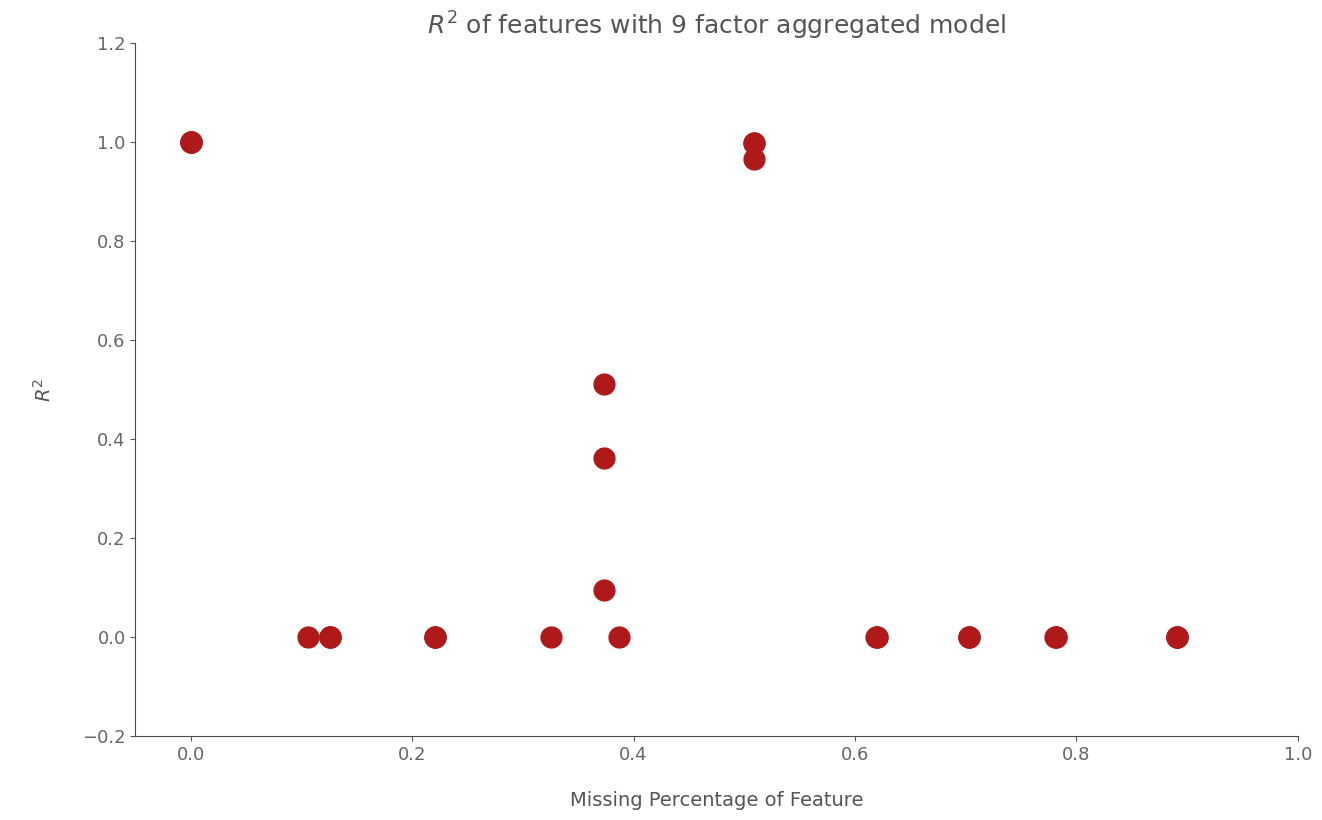

In [ ]:
mat.plot_gridsearch_trends()

During the imputation, once we have the number of factors decided, we can retrain on all of the data: 

In [17]:
mat.run_completion(9, use_full_matrix=True) 

Running matrix completion for 9 factors:

Overall R^2 value:
0.4910265186061732
Repeating completion without masking for 9 factors


(array([[ 0.12566579, -0.13990025, -0.09530424, ..., -0.0164399 ,
         -0.95958941, -0.04688455],
        [ 0.14575157, -0.14824219, -0.09120185, ..., -0.01288288,
         -0.95670798, -0.0567373 ],
        [ 0.13126425, -0.13139628, -0.08411861, ..., -0.01477334,
         -0.95886895, -0.04936084],
        ...,
        [-0.16490524, -0.09354992, -0.10981496, ...,  0.01339854,
         -0.47710533,  0.00272759],
        [-0.16451839, -0.09008699, -0.1133466 , ..., -0.00117888,
          0.07195891, -0.03799793],
        [-0.1648268 , -0.09352572, -0.10977875, ...,  0.01339432,
         -0.47710567,  0.00275402]]),
 0.4910265186061732,
                        Feature  Missing_percentage  Imputation_r2  \
 0        a_prior_freq_AvE_lag5            0.619275   -2901.436953   
 1   a_prior_loss_AvE_c_dc_lag5            0.619504   -2820.491214   
 2        a_prior_loss_AvE_lag5            0.619504   -2518.768084   
 3   a_prior_loss_AvE_c_dc_lag6            0.703203     -12.167656   
 4

### Online imputation

Now we perform the impuation on a new observation. The new observation should be in the same format as the other observations and we can use our already completed matrix. The gridsearch will have automatically selected the imputation with the highest $R^2$, so if we want a specific number of factors we would have to run the completion for that number. 

Remembering how the matrix completion works, we factorize a matrix $X$ to be: 

$$X = UV, \quad X \in \mathbb{R}^{n \times m}, U \in \mathbb{R}^{n \times k}, V \in \mathbb{R}^{k \times m}$$

where $k$ is the number of factors. We then have a new observation $\boldsymbol{x_i}$, and $X \rightarrow X'$. We now want to minimize the loss, and since this adds just a new row to $X$, we get: 

$$L(X'-U'V) = L(X-UV) + L(\boldsymbol{x_i} - \boldsymbol{u_i}V)$$

and we can minimize $L(\boldsymbol{x_i} - \boldsymbol{u_i}V)$ to impute without retraining. Our objective function is to find 

$$\boldsymbol{u^{*}_{i}} = argmin_{\boldsymbol{u}} \sum_{obs} (x_{ij} - (\boldsymbol{u_i}V)_j)^2$$

and reconsruct the new row as:
$$\hat{\boldsymbol{x_i}}=\boldsymbol{u^*_i}V$$

Let's choose some of the rows at random from the data as a new observation: 

In [ ]:
new_obs = df_bucket_X.iloc[myRandom.sample(B, 3)]

In [ ]:
new_obs

,a_onleveltrnd_lc_amt,a_totpayroll8810_amt,a_totpayroll_amt,emod_calc,a_dnb_score,a_osha_insp_ct_10y,a_OSHA_viol_ct_10y,a_OSHA_Willful_Ct_10y,a_OSHA_Repeat_Ct_10y,a_prior_freq_AvE_lag1,...,a_prior_loss_AvE_c_dc_lag7,a_prior_loss_AvE_lag1,a_prior_loss_AvE_lag2,a_prior_loss_AvE_lag3,a_prior_loss_AvE_lag4,a_prior_loss_AvE_lag5,a_prior_loss_AvE_lag6,a_prior_loss_AvE_lag7,loss_free_ct,a_wage_ave_c
31752,-0.115226,-0.074225,-0.089301,-1.489006,0.363575,NaN,NaN,NaN,NaN,-0.008169,...,NaN,-0.007699,-0.008317,-0.008448,-0.012967,-0.008059,-0.013851,NaN,1.495200,-0.009803
7395,-0.164428,-0.083601,-0.119708,0.147454,-1.876186,NaN,NaN,NaN,NaN,-0.008169,...,NaN,-0.007699,-0.008317,-0.008448,-0.012967,NaN,NaN,NaN,1.002074,NaN
24716,-0.111358,-0.076958,-0.105741,1.565720,0.453109,NaN,NaN,NaN,NaN,-0.008162,...,NaN,-0.007699,-0.008316,-0.008447,-0.012966,NaN,NaN,NaN,-0.970431,-0.009803


In [ ]:
mat.impute_new_data(new_obs)

,a_onleveltrnd_lc_amt,a_totpayroll8810_amt,a_totpayroll_amt,emod_calc,a_dnb_score,a_osha_insp_ct_10y,a_OSHA_viol_ct_10y,a_OSHA_Willful_Ct_10y,a_OSHA_Repeat_Ct_10y,a_prior_freq_AvE_lag1,...,a_prior_loss_AvE_c_dc_lag7,a_prior_loss_AvE_lag1,a_prior_loss_AvE_lag2,a_prior_loss_AvE_lag3,a_prior_loss_AvE_lag4,a_prior_loss_AvE_lag5,a_prior_loss_AvE_lag6,a_prior_loss_AvE_lag7,loss_free_ct,a_wage_ave_c
0,-0.035234,-0.105540,-0.110485,-1.485776,0.342430,-0.193795,-0.155345,0.099244,-0.237413,-0.008908,...,-0.006542,-0.008535,-0.008508,-0.009405,-0.011988,-0.007714,-0.017105,0.009491,1.500928,-0.030043
1,-0.165693,-0.089261,-0.113382,0.147487,-1.876150,3.333139,4.241437,-0.496064,2.972076,-0.008880,...,0.203964,-0.008502,-0.008403,-0.008038,-0.011622,-0.007773,-0.071949,0.283689,1.002141,1.871381
2,-0.107985,-0.070514,-0.114199,1.565749,0.452598,2.440558,-1.244725,5.391031,-5.768989,-0.010967,...,25.379935,-0.007871,-0.008208,-0.008522,-0.018060,-0.370381,-6.720871,29.320477,-0.970387,-0.010249


### Plot a histogram of the missing data by row and cumulative missingness:

Some visualisations of the missingness in the dataset. 

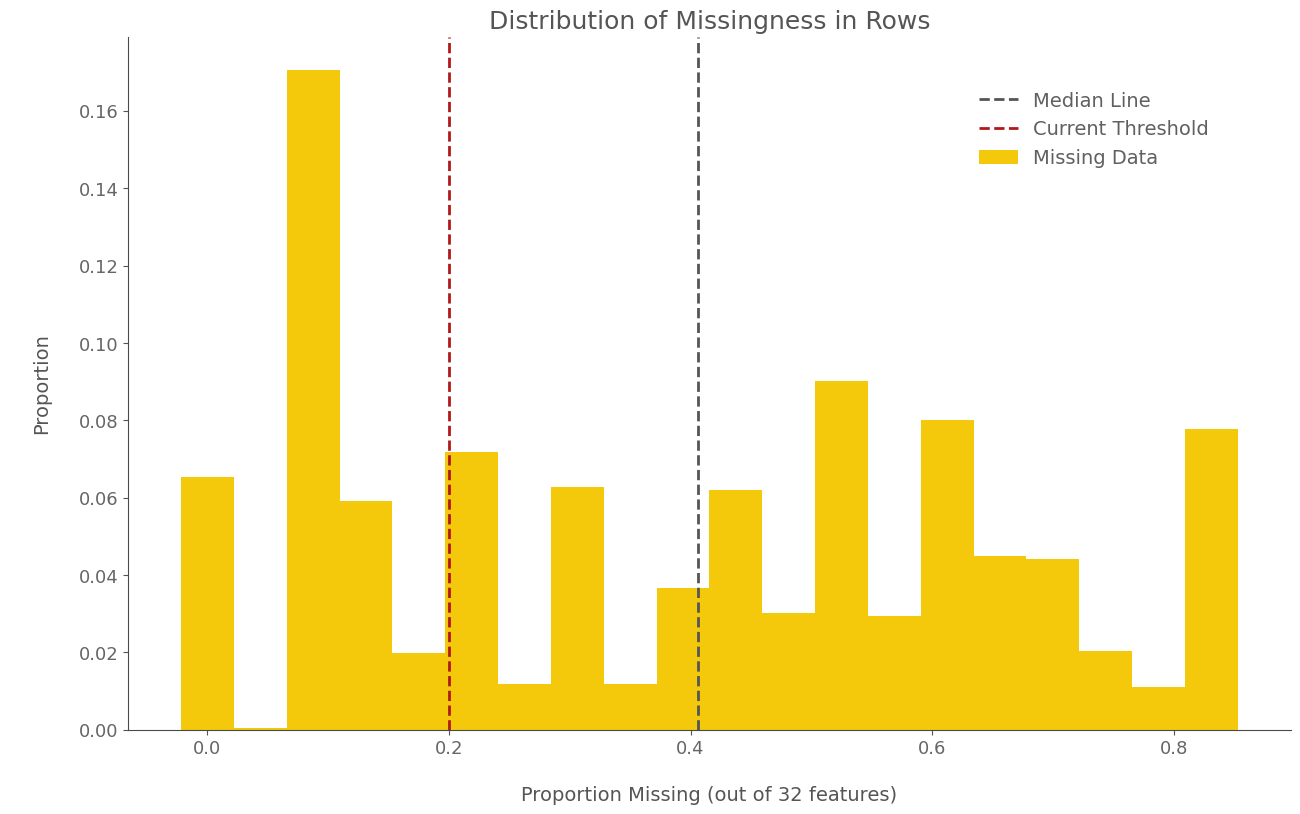

In [ ]:
# Plot a histogram of the missingness by row in the data

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize = (15,9))
mpl.rcParams['text.color'] = '#555555'
plt.hist(df_bucket_X.isnull().sum(axis=1)/ df_bucket_X.shape[1], bins=20, align='left', color = '#f4c90b', weights=[1/df_bucket_X.shape[0]] * df_bucket_X.shape[0])

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color('#4a4a4a')
ax.spines["bottom"].set_color('#4a4a4a')


ax.tick_params(color = '#555555', labelcolor = '#555555')
plt.xticks(fontsize = 13, color = '#666666')
plt.yticks(fontsize = 13, color = '#666666')
plt.title('Distribution of Missingness in Rows', fontsize = 18, color = '#555555')
ax.set_ylabel('\nProportion\n', rotation=90, position = (0.3,0.5), fontsize = 14, color = '#555555')
ax.set_xlabel('\nProportion Missing (out of 32 features)', fontsize = 14, color = '#555555')
plt.axvline((df_bucket_X.isnull().sum(axis=1) /  df_bucket_X.shape[1]).median(), linestyle='dashed', linewidth=2, color = '#555555')
plt.axvline(0.2, linestyle='dashed', linewidth=2, color ='#b01919')
plt.legend(loc = (0.725, 0.8), frameon = False, fontsize = 14, labelcolor = '#606060', labels = ['Median Line', 'Current Threshold', "Missing Data"])

plt.show()

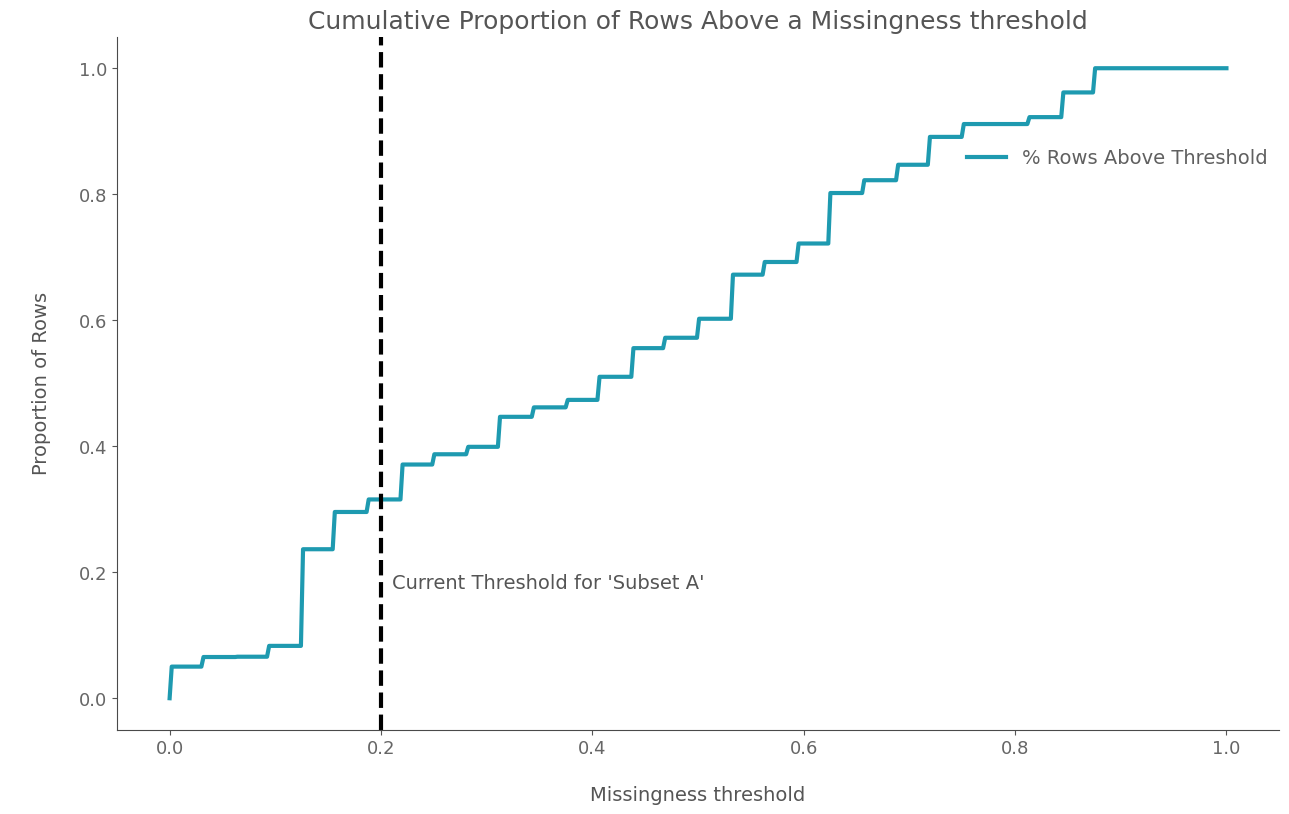

In [ ]:
# cumulative distribution
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize = (15,9))
mpl.rcParams['text.color'] = '#555555'

x = np.linspace(start=0, stop=1, num=500).tolist()
cum_dist = []
for item in x:
    cum_dist.append((df_bucket_X.isnull().sum(axis=1) / df_bucket_X.shape[1] < item).sum() / df_bucket_X.shape[0])

plt.plot(x, cum_dist, linewidth=3, color = '#1e9ab0')


ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color('#4a4a4a')
ax.spines["bottom"].set_color('#4a4a4a')

ax.tick_params(color = '#555555', labelcolor = '#555555')
plt.xticks(fontsize = 13, color = '#666666')
plt.yticks(fontsize = 13, color = '#666666')
plt.title('Cumulative Proportion of Rows Above a Missingness threshold', fontsize = 18, color = '#555555')
ax.set_ylabel('\nProportion of Rows\n', rotation=90, position = (0.3,0.5), fontsize = 14, color = '#555555')
ax.set_xlabel('\nMissingness threshold', fontsize = 14, color = '#555555')

plt.axvline(0.2, color='k', linestyle='dashed', linewidth=3)
ax.text(0.21, 0.175, 'Current Threshold for \'Subset A\'', fontsize = 14, color = '#555555' )

plt.legend(loc = (0.725, 0.8), frameon = False, fontsize = 14, labelcolor = '#606060', labels = ["% Rows Above Threshold"])
plt.show()

### Set up the functions to mask the data to evaluate the matrix completion
More in-depth details are in the overleaf document on the methodology and background to the sampling. 

We partition in sets A and B and then perform our patterned masking, keeping track of which indices were masked. 


In [ ]:
# row overlay function to copy the missingness pattern
# imposes the pattern of a row from B onto a row from A

def row_overlay(row1, row2):
    resultant_row = np.where(row1.isna(),
                             np.nan,
                             row2)
    return(resultant_row)

In [ ]:
# function to do the sampling in one place
# takes in the data and a threshold, and outputs the masked dataframe, 
# the targets, the patterns, and the true standardised matrix
import random
def mask_data(df_to_mask, threshold=0.2):
    
    # partition based on missingness threshold 
    partition = df_to_mask.isnull().sum(axis=1) / df_to_mask.shape[1] <= threshold 
    
    # get partition indices
    A = []
    B = []
    idx = 0
    for item in partition:
        if item:
            A.append(idx)
        else:
            B.append(idx)
        idx += 1
        
    # get some summary stats for the partition 
    num_true = (partition).sum()
    perc_true = num_true / df_to_mask.shape[0]
    B_missing = (df_to_mask.iloc[B, :].isnull().sum(axis=1) / df_to_mask.shape[1]).mean()
    A_missing = (df_to_mask.iloc[A, :].isnull().sum(axis=1) / df_to_mask.shape[1]).mean()
    summary_df = pd.DataFrame({
        'Category': ['Subset A', 'Subset B'],
        'Size': [num_true, df_to_mask.shape[0] - num_true],
        'Percentage of Total': [perc_true, 1 - perc_true],
        'Percentage Missing':[A_missing, B_missing]
    })
        
    
    random.seed(2022)
    
    # standardise the matrix
    true_matrix_standardised = df_to_mask.copy()
    
    # get a copy which we will then mask, sampling 10% of the total number of rows from each of A and B
    masked_copy = true_matrix_standardised.copy()
    B_patterns = random.sample(B, int(round(.1*masked_copy.shape[0])))
    A_targets = random.sample(A, int(round(.1*masked_copy.shape[0])))

    for i in range(len(B_patterns)):
        B_row = masked_copy.iloc[B_patterns[i]]
        A_row = masked_copy.iloc[A_targets[i]]
        masked_copy.iloc[A_targets[i]] = row_overlay(B_row, A_row)
    return(masked_copy, A_targets, B_patterns, true_matrix_standardised, summary_df)


# run the function to get the needed features
mar_copy, A_targets, B_patterns, true_matrix_standardised, summary_df = mask_data(df_bucket_X)


In [ ]:
summary_df

,Category,Size,Percentage of Total,Percentage Missing
0,Subset A,12421,0.315518,0.108596
1,Subset B,26946,0.684482,0.541319


In [ ]:
# build the missing indices matrix using the targets and patterns
# returns a 0-1 matrix, 1 if masked and 0 otherwise

def get_missing_indices_matrix(masked_copy, B_patterns, A_targets):
    
    # create a matrix of 0s the same size as the dataframe
    missing_indices_matrix = np.zeros((masked_copy.shape[0], masked_copy.shape[1]))
    
    # for each of the patterns, find its associated target. 
    for i in range(len(B_patterns)):
        A_row = A_targets[i]
        missing_indices_matrix[A_row, :] = masked_copy.iloc[B_patterns[i]].isna()

    return(missing_indices_matrix)

missing_indices_matrix = get_missing_indices_matrix(mar_copy, B_patterns, A_targets)

In [ ]:
# save the missing indices matrix that we used with the 2022 seed

pd.DataFrame(missing_indices_matrix, columns=true_matrix_standardised.columns).to_csv('missing_ind_matrix_agg_2022seed.csv', index=False)

Now that we have masked data, we can see how successful it was:

In [ ]:
# check how successful our removal of data was compared to the original data

na_percs = []
na_counts = []

for column in mar_copy.columns:
    na_percs.append(mar_copy[column].isna().sum() / mar_copy.shape[0])
    na_counts.append(mar_copy[column].isna().sum())
    
colnames = mar_copy.columns.tolist()

# get a sorted dataframe of the number of missing values
mar_copy_missingness_df = pd.DataFrame({"Feature": colnames,
                                "percent_missing": na_percs,
                                "number_missing": na_counts})

# now do the same thing just for the features in our baseline model
na_percs = []
na_counts = []

for column in df_bucket_X.columns:
    na_percs.append(df_bucket_X[column].isna().sum() / df_bucket_X.shape[0])
    na_counts.append(df_bucket_X[column].isna().sum())

    
true_values_missingness_df = pd.DataFrame({"Feature": df_bucket_X.columns,
                                "percent_missing": na_percs,
                                "number_missing": na_counts})

mar_copy_missingness_df = mar_copy_missingness_df.sort_values(by = ["percent_missing"], ascending=True)
true_values_missingness_df = true_values_missingness_df.sort_values(by = ["percent_missing"], ascending=True)

In [ ]:
true_values_missingness_df.tail()

,Feature,percent_missing,number_missing
29,a_prior_loss_AvE_lag7,0.693398,27297
8,a_OSHA_Repeat_Ct_10y,0.860365,33870
7,a_OSHA_Willful_Ct_10y,0.860365,33870
6,a_OSHA_viol_ct_10y,0.860365,33870
5,a_osha_insp_ct_10y,0.860365,33870


In [ ]:
mar_copy_missingness_df.tail()

,Feature,percent_missing,number_missing
29,a_prior_loss_AvE_lag7,0.781162,30752
8,a_OSHA_Repeat_Ct_10y,0.890390,35052
7,a_OSHA_Willful_Ct_10y,0.890390,35052
6,a_OSHA_viol_ct_10y,0.890390,35052
5,a_osha_insp_ct_10y,0.890390,35052


We should have increased the missingness by approximately 10%:

In [ ]:
true_values_missingness_df.percent_missing.mean()

0.4047870043437397

In [ ]:
mar_copy_missingness_df.percent_missing.mean()

0.4492436558538878

### Matrix completion:

Now we set up the matrix completion functions. More details on the functions and maths are included in the overleaf document. We use singular value decomposition to select the needed number of factors

In [ ]:
# hard impute is the matrix completion function. 
# O is the original matrix to be completed with the missing values replaced by 0
# Ω is a 0-1 matrix with 0 where the matrix has missing values and 1 otherwise
# r is the number of factors
# the tolerance is a value to tune for convergence

def hard_impute(O, Ω, r=1, tolerance=1e-4):
    M = np.zeros_like(O)
    for T in range(4000):
        M_new = SVD(O * Ω + (1-Ω) * M , r)
        print('Iteration:', T, end = "\r")
        if (np.linalg.norm(M-M_new) < np.linalg.norm(M)*tolerance):
            break
        M = M_new
    return M

# the SVD returns a matrix with low rank imposed. 
# we use only the first r singular decomposition values.
def SVD(M, r):
    u,s,vh = np.linalg.svd(M, full_matrices=False)
    s[r:] = 0
    return (u*s).dot(vh)


A helper function for the hard_impute, getting the matrix in the right form and setting up the $\Omega$ matrix

In [ ]:
# get the omega matrix and raw for the hard impute. Replace missings with 0 and
# make omega a matrix of 0 and 1 for missing and not
def get_raw_omega_mats(masked_copy):
    omega_st = masked_copy.copy()
    raw_st = masked_copy.copy() 

    for col in omega_st.columns:
        omega_st[col] = np.where((omega_st[col].isna()),
            0,
            1)

    for col in raw_st.columns:
        raw_st[col] = np.where((raw_st[col].isna()),
            0,
            raw_st[col])
    omega_st = np.array(omega_st)
    raw_st = np.array(raw_st)
    
    return(omega_st, raw_st)
omega_st, raw_st = get_raw_omega_mats(mar_copy)

Now we set up the function to measure the $R^2$ of the matrix completion as outlined in the overleaf document. 

We include the boosting section when measing the individual features. The $R^2$ formula for a feature is essentially: 

$$R^2 = 1 - \frac{\sum(\hat{y}_i - y_i)^2}{\sum(\bar{y} - y_i)^2}$$

This is done for each feature, and then overall for all features

In [ ]:
# find r2 by column
# returns a dataframe of the R^2 scores for each feature and the overall R^2
def r2_by_column(missing_indices_matrix, mar_matrix, true_df, imputed_matrix, A_targets):

    na_percs = []
    for column in mar_copy.columns:
        na_percs.append(mar_copy[column].isna().sum() / mar_copy.shape[0])
        
    r2_cols = []
    r2_reals = []
    
    # initialise variables to keep track of the numerator and denominator in our overall R^2 calculation
    toptot = 0
    bottomtot = 0
    for i in range(missing_indices_matrix.shape[1]):
                
        # get the validation indices for the boosting regression
        # these are the values that were actually masked (row numbers)
        missing_keys = sorted(A_targets)
        
        # get the training set indices
        # all the other values that were not masked we can train on - the complement of the masked values
        train_indices = list(set(range(mar_matrix.shape[0])) - set(A_targets))
        
        #get validation x and y
        valid_y = true_df.iloc[missing_keys, i]
        one_zero_col_val = np.array([int(x) for x in missing_indices_matrix[missing_keys, i]])
        
        # we only want to include the values that we removed artificially, so set the others to nan for validation
        # essentially, we ignore any values that were not masked during the sampling process since
        # the regression ignores nans
        valid_y = np.where(one_zero_col_val == 0,
                            np.nan,
                            valid_y)
        valid_x = imputed_matrix[missing_keys, i]
        
        # now get the training x and y. Ensure we exclude the validation set
        # we make sure we include only values that were not masked 
        train_x = imputed_matrix[train_indices, i]
        train_y = true_df.iloc[train_indices, i]#
        one_zero_col_train = np.array([int(x) for x in missing_indices_matrix[train_indices, i]])
        train_y = np.where(one_zero_col_train == 1,
                    np.nan,
                    train_y)
        
        # set up easy to use dataframes for the regression
        train_df = pd.DataFrame({
            "X": train_x,
            "Y": train_y
        })
        train_df.dropna(inplace=True)
        
        valid_df = pd.DataFrame({
            "X": valid_x,
            "Y": valid_y
        })
        valid_df.dropna(inplace=True)
        
        if sum(one_zero_col_val) == 0:
            r2 = 1
            r2_real = 1
            top, bottom = 0, 0
            
        else:   
            # train the regression on the training data
            model = LinearRegression()
            model.fit(np.array(train_df["X"]).reshape(-1, 1), np.array(train_df["Y"]))
            in_sample_rsq = model.score(np.array(train_df["X"]).reshape(-1, 1), np.array(train_df["Y"]))

            # get the OOS r^2 
            # make sure we use the mean from the training data in the denominator
            predictions = model.predict(np.array(valid_df["X"]).reshape(-1, 1))
            col_mean = np.mean(train_df["Y"]) 

            # use the r^2 formula
            top = np.nansum(np.subtract(predictions, valid_df["Y"]) ** 2)
            bottom = np.nansum((valid_df["Y"] - col_mean) ** 2) 
            r2 = 1 - top / bottom     
            
            # try to get the real r2, not only from boosting
            top = np.nansum(np.subtract(valid_df["X"], valid_df["Y"]) ** 2)
            bottom = np.nansum((valid_df["Y"] - col_mean) ** 2) 
            r2_real = 1 - top / bottom    
        
        r2_cols.append(r2)
        r2_reals.append(r2_real)
        
        # keep track for our overall R^2
        toptot += top
        bottomtot += bottom
        
    r2_by_column = pd.DataFrame({
        "Feature" : true_df.columns,
        "Missing_percentage" : na_percs,
        "Imputation_r2" : r2_cols,
        "Raw_r2_imputed":r2_reals
    })  
    r2_tot = r2 = 1 - toptot / bottomtot
    print('R^2:')
    print(r2_tot)
    
    return(r2_tot, r2_by_column)

In [ ]:
# basic gridsearch to fin the best r2 value

# ---------------------------------------------------------

# takes some time to run - best for agg model has so far been 16 factors

# ---------------------------------------------------------

r2s = []
Ms = []
grid_range = (2, 20)
for i in range(grid_range[0], grid_range[1]):
    M = hard_impute(raw_st, omega_st, i, tolerance = 1e-2)
    Ms.append(M)
    r2, r2_cols = r2_by_column(missing_indices_matrix, mar_copy, true_matrix_standardised, M, A_targets)
    r2s.append(r2)

R^2:ation: 5
0.4671281017624327
R^2:ation: 5
0.4701126954695164
R^2:ation: 33
-0.46219884754918517
R^2:ation: 50
-0.7696676558363094
R^2:ation: 38
-0.31345706464716105
R^2:ation: 36
-0.371107216904595
R^2:ation: 32
0.2832914428500427
R^2:ation: 47
0.47504750977154353
R^2:ation: 38
0.4606898816506616
R^2:ation: 28
0.2095426238756264
R^2:ation: 34
0.04979326625144942
R^2:ation: 3
0.003982339848373151
R^2:ation: 3
0.0039407632445987995
R^2:ation: 1
0.0010283122263804456
R^2:ation: 4
-0.001174799307583907
R^2:ation: 1
0.00069935322879211
R^2:ation: 1
0.0007023763829306917
R^2:ation: 1
0.0004568626200517345


In [ ]:
# choose the best number of factors and run again with even lower tolerance to ensure comlete convergence
max_r2 = max(r2s)
best_index = r2s.index(max_r2)
factors = list(range(grid_range[0], grid_range[1]))[best_index]

print('Best number of factors:')
print(factors)

Best number of factors:
9


In [ ]:
Mat = hard_impute(raw_st, omega_st, range(grid_range[0], grid_range[1])[best_index], tolerance = 1e-3)
r2, r2_cols = r2_by_column(missing_indices_matrix, mar_copy, true_matrix_standardised, Mat, A_targets)

R^2:ation: 327
0.49303513442949476


In [ ]:
r2_cols.sort_values(by = ["Imputation_r2"], ascending=True)

,Feature,Missing_percentage,Imputation_r2,Raw_r2_imputed
13,a_prior_freq_AvE_lag5,0.619275,-2588.510477,-2588.449266
20,a_prior_loss_AvE_c_dc_lag5,0.619504,-2516.114492,-2516.057095
27,a_prior_loss_AvE_lag5,0.619504,-2246.941981,-2246.887146
21,a_prior_loss_AvE_c_dc_lag6,0.703203,-11.194772,-11.501297
14,a_prior_freq_AvE_lag6,0.703000,-11.114465,-11.413603
28,a_prior_loss_AvE_lag6,0.703203,-4.267632,-4.468601
23,a_prior_loss_AvE_lag1,0.126045,-1.734074,-1.332679
24,a_prior_loss_AvE_lag2,0.220642,-0.631754,-0.595266
10,a_prior_freq_AvE_lag2,0.220591,-0.627610,-0.606700
17,a_prior_loss_AvE_c_dc_lag2,0.220642,-0.610277,-0.578818


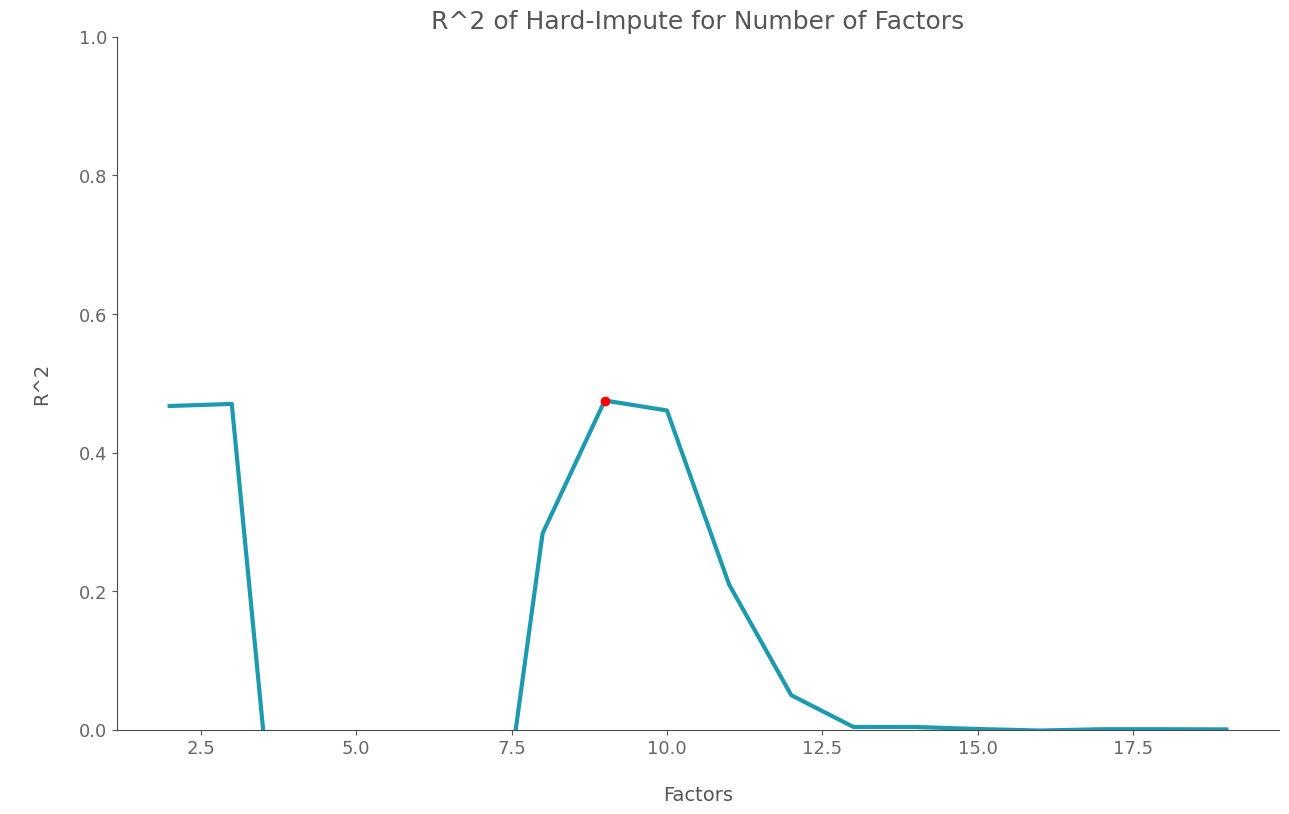

In [ ]:
# plot the line search results
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize = (15,9))
mpl.rcParams['text.color'] = '#555555'

x = range(grid_range[0], grid_range[1])
plt.plot(x, r2s, linewidth=3, color = '#1e9ab0')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color('#4a4a4a')
ax.spines["bottom"].set_color('#4a4a4a')

ax.tick_params(color = '#555555', labelcolor = '#555555')
plt.xticks(fontsize = 13, color = '#666666')
plt.yticks(fontsize = 13, color = '#666666')
plt.title('R^2 of Hard-Impute for Number of Factors', fontsize = 18, color = '#555555')
ax.set_ylabel('\nR^2\n', rotation=90, position = (0.3,0.5), fontsize = 14, color = '#555555')
ax.set_xlabel('\nFactors', fontsize = 14, color = '#555555')
plt.plot(x[best_index], r2s[best_index],'o', color='red')
plt.ylim([0, 1])
# plt.text(15.5, 0.8, '16 Factors', fontsize = 14, color = '#555555')
# plt.legend(loc = (0.725, 0.8), frameon = False, fontsize = 14, labelcolor = '#606060', labels = ["% Rows Above Threshold", "6 Factors", "10 Factors"])
plt.show()

In [ ]:
# save the imputed matrix for use in other notebooks: 
pd.DataFrame(Mat, columns=true_matrix_standardised.columns).to_csv('{}_factor_agg.csv'.format(factors), index=False)


R^2:
0.49303513442949476


/tmp/ipykernel_19983/1739166141.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


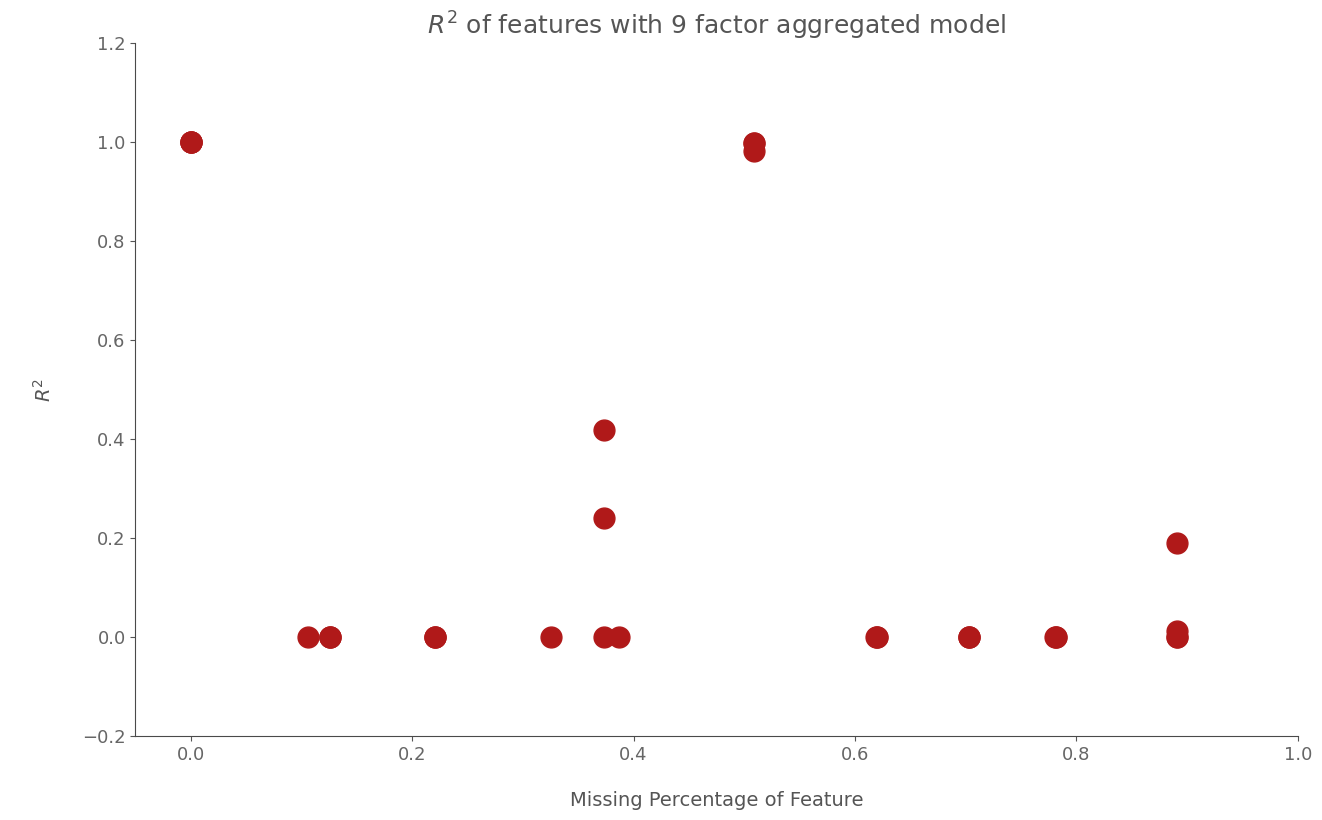

In [ ]:
# plot the trend of the r^2 values and the missingness of the data

r2, r2_cols = r2_by_column(missing_indices_matrix, mar_copy, true_matrix_standardised, Mat, A_targets)
r2_cols.sort_values(by = ["Imputation_r2"], ascending=True, inplace=True)
r2_cols.Imputation_r2 = np.where(r2_cols.Imputation_r2 < 0,
                                 0, 
                                 r2_cols.Imputation_r2)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')


mpl.rcParams.update(mpl.rcParamsDefault)
fig, ax = plt.subplots(figsize = (15,9))
mpl.rcParams['text.color'] = '#555555'
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_color('#4a4a4a')
ax.spines["bottom"].set_color('#4a4a4a')

ax.tick_params(color = '#555555', labelcolor = '#555555')
plt.xticks(fontsize = 13, color = '#666666')
plt.yticks(fontsize = 13, color = '#666666')
plt.title('$R^{}$ of features with {} factor aggregated model'.format(2, factors), fontsize = 18, color = '#555555')
ax.set_ylabel('\n$R^{2}$\n', rotation=90, position = (0.3,0.5), fontsize = 14, color = '#555555')
ax.set_xlabel('\nMissing Percentage of Feature', fontsize = 14, color = '#555555')
plt.plot(r2_cols.Missing_percentage, r2_cols.Imputation_r2, 'o', color='#b01919', markersize=15)

# plt.text(0.64, 0.582935, 'a_prior_loss_AvE_lag5', fontsize = 14, color = '#555555')
# plt.text(0.15, 0.41, 'a_prior_loss_AvE_lag1', fontsize = 14, color = '#555555')
plt.xlim([-0.05, 1])
plt.ylim([-0.2, 1.2])
plt.show()

In [ ]:
# save the sorted and cropped r2 columns for the modelling later on

r2_cols.to_csv('r2_columns_dataframe_{}_factors.csv'.format(factors))

In [ ]:
r2_cols

,Feature,Missing_percentage,Imputation_r2,Raw_r2_imputed
13,a_prior_freq_AvE_lag5,0.619275,0.000000,-2588.449266
20,a_prior_loss_AvE_c_dc_lag5,0.619504,0.000000,-2516.057095
27,a_prior_loss_AvE_lag5,0.619504,0.000000,-2246.887146
21,a_prior_loss_AvE_c_dc_lag6,0.703203,0.000000,-11.501297
14,a_prior_freq_AvE_lag6,0.703000,0.000000,-11.413603
28,a_prior_loss_AvE_lag6,0.703203,0.000000,-4.468601
23,a_prior_loss_AvE_lag1,0.126045,0.000000,-1.332679
24,a_prior_loss_AvE_lag2,0.220642,0.000000,-0.595266
10,a_prior_freq_AvE_lag2,0.220591,0.000000,-0.606700
17,a_prior_loss_AvE_c_dc_lag2,0.220642,0.000000,-0.578818


In [ ]:
pd.read_csv('missing_ind_matrix_agg_2022seed.csv').a_totpayroll8810_amt.sum()

0.0

In [ ]:
Mat = hard_impute(raw_st, omega_st, factors, tolerance = 0.5e-4)
r2, r2_cols = r2_by_column(missing_indices_matrix, mar_copy, true_matrix_standardised, Mat, A_targets)

R^2:ation: 3999
-0.3062088158171674
